In [1]:
import os
import ast
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
import shapely
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [3]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode
facilityQuery = '''SELECT COUNT (cartodb_id), zipcodes 
FROM nycasthmasdismissals
GROUP BY zipcodes
'''
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilities     = pd.DataFrame(facilityData['rows'])
facilities.columns = ['Count', 'ZIPCODE']
facilities['ZIPCODE'] = facilities['ZIPCODE'].apply(pd.to_numeric)
facilities

,Count,ZIPCODE
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375
5,494,10466
6,713,11212
7,167,11229
8,521,11215
9,386,11220


In [4]:
# Load zipcode shapefile and reduce columns
shape_path = os.getenv("PUIDATA") + "/ExtraCredit_HW12/ZIP_CODE_040114.shp"
zipcode_shape = gpd.GeoDataFrame.from_file(shape_path)
zipcode_reduced = zipcode_shape[["ZIPCODE", "geometry"]]
zipcode_reduced["ZIPCODE"] = zipcode_reduced["ZIPCODE"].apply(pd.to_numeric)
zipcode_reduced.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [5]:
# Convert geometry field to zipcode centroid data
zipcode_reduced['geometry'] = gpd.GeoSeries(zipcode_reduced.centroid)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [6]:
#merge datasets together on the ZIPCODE column
zipcode_merged = zipcode_reduced.merge(facilities, on = 'ZIPCODE')
zipcode_merged.head()

,ZIPCODE,geometry,Count
0,11213,POINT (1001912.871996466 183803.1131420481),376
1,11212,POINT (1008365.375095716 180768.9448568909),713
2,11219,POINT (985172.779324743 169813.4852984693),421
3,10466,POINT (1026647.114925691 263909.2896452093),494
4,10467,POINT (1020059.119296007 259287.5178783316),2164


In [7]:
# Create 3 dimensional array, length equal to merged zipcode data (29 records)
krigdata = np.zeros((len(zipcode_merged),3))
krigdata

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [8]:
# Write merge data into the array

for x in range(len(krigdata)):
    krigdata[x][0] = zipcode_merged.Count[x]
    krigdata[x][1] = zipcode_merged.geometry[x].x
    krigdata[x][2] = zipcode_merged.geometry[x].y

krigdata

array([[  3.76000000e+02,   1.00191287e+06,   1.83803113e+05],
       [  7.13000000e+02,   1.00836538e+06,   1.80768945e+05],
       [  4.21000000e+02,   9.85172779e+05,   1.69813485e+05],
       [  4.94000000e+02,   1.02664711e+06,   2.63909290e+05],
       [  2.16400000e+03,   1.02005912e+06,   2.59287518e+05],
       [  1.69900000e+03,   1.02829272e+06,   2.47902428e+05],
       [  8.22000000e+02,   1.01237400e+06,   2.47427241e+05],
       [  1.07200000e+03,   1.00976434e+06,   2.41746681e+05],
       [  1.69800000e+03,   1.00535896e+06,   2.38316068e+05],
       [  2.81000000e+02,   1.00461252e+06,   2.20393721e+05],
       [  6.41000000e+02,   1.03375196e+06,   2.13025445e+05],
       [  1.15600000e+03,   1.00620449e+06,   1.95763534e+05],
       [  4.66000000e+02,   1.00021475e+06,   1.95030042e+05],
       [  9.40000000e+02,   9.87194513e+05,   1.92431928e+05],
       [  5.21000000e+02,   9.89857162e+05,   1.81769963e+05],
       [  1.82900000e+03,   1.00248639e+06,   1.7596792

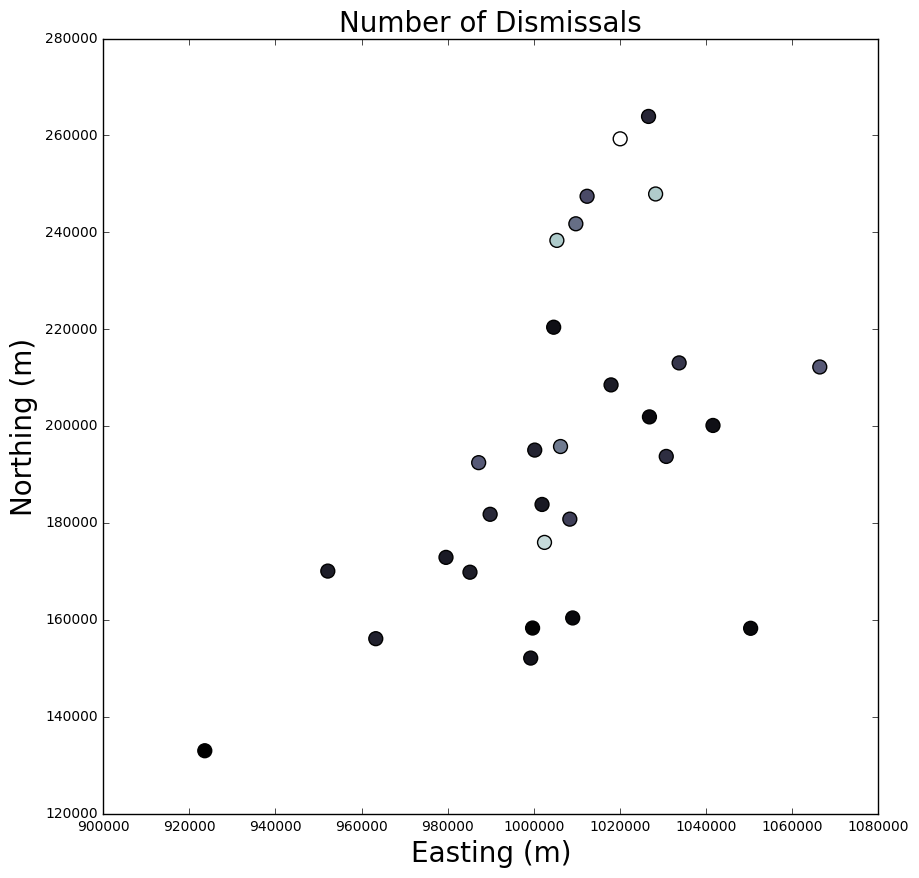

In [10]:
#plot the array
pl.figure(figsize=(10,10))
pl.scatter(krigdata[:,1], krigdata[:,2], c=krigdata[:,0], s=100, cmap='bone')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
plt.title("Number of Dismissals", fontsize = 20)

### Figure 1. Facility Dismissals for Asthma by Zipcode Center